# Produce an HRSL-based Dataset with Uganda Populations

The incoming data are

* HRSL - the high-resolution settlement layer. This knows rooftops. It's on a 30m grid.
  It gets house locations right, but the people per house comes from unknown administrative
  data from Uganda, so we throw that out.

* LandScan - Populations on a 1000m grid. This does better in the cities, but the data
  comes from geospatial statistics, so it may predict people where there are no people.
  
* UBOS - This has district-level totals, but it's surprisingly hard to get subcounty-level
  totals because subcounty administrative borders change fast.
  
So the plan is to get a dataset that has the following properties.

1. There is a value at each residence specified by the HRSL.

2. The total people per district matches UBOS predictions.

3. The weight on each house comes from LandScan.

In [8]:
using ArchGDAL
using BenchmarkTools
using Colors
using GDAL
using ImageView
using Images
using ImageMagick
using Plots

GLib-GIO-Message: 08:04:51.806: Using the 'memory' GSettings backend.  Your settings will not be saved or shared with other applications.


## Load Data

In [9]:
base_path = "~/data"
paths = Dict{Symbol, Any}(
    :subcounty => joinpath(
       base_path, "projects", "uganda2020", "outputs",
       "uganda_subcounties_2019_topology_fix", "uganda_subcounties_2019_topology_fix.shp"),
    :hrsl => joinpath(base_path, "inputs", "HRSL", "uganda2018", "hrsl_uga_settlement.tif"),
    :landscan => joinpath(base_path, "inputs", "landscan", "LandScan Global 2018", "lspop2018", "w001001.adf")
    )
for (path_kind, path_loc) in paths
    paths[path_kind] = expanduser(path_loc)
    @assert isfile(paths[path_kind])
end

In [10]:
subcounty = ArchGDAL.read(paths[:subcounty])

GDAL Dataset (Driver: ESRI Shapefile/ESRI Shapefile)
File(s): 
  /home/adolgert/data/projects/uganda2020/outputs/uganda_subcounties_2019_topology_fix/uganda_subcounties_2019_topology_fix.shp
  /home/adolgert/data/projects/uganda2020/outputs/uganda_subcounties_2019_topology_fix/uganda_subcounties_2019_topology_fix.shx
  /home/adolgert/data/projects/uganda2020/outputs/uganda_subcounties_2019_topology_fix/uganda_subcounties_2019_topology_fix.dbf
  /home/adolgert/data/projects/uganda2020/outputs/uganda_subcounties_2019_topology_fix/uganda_subcounties_2019_topology_fix.prj

Number of feature layers: 1
  Layer 0: uganda_subcounties_2019_topology_fix (wkbPolygon)


In [11]:
subcounty_layer = ArchGDAL.getlayer(subcounty, 0)
ArchGDAL.getfeature(subcounty_layer, 0) do feature
    print(feature)
end

Feature
  (index 0) geom => POLYGON
  (index 0) OBJECTID => 473
  (index 1) District => KOBOKO
  (index 2) Dcode => 319
  (index 3) County => KOBOKO
  (index 4) CCode => 3191
  (index 5) Subcounty => LUDARA
  (index 6) Poverty => 25.8
  (index 7) ChPoverty => 27.2
  (index 8) regions => Northern
  (index 9) scode2019 => 319106
...
 Number of Fields: 11

In [14]:
hrsl_ds = ArchGDAL.read(paths[:hrsl])
@show hrsl_ref = ArchGDAL.getproj(hrsl_ds)
@show hrsl_geotransform = ArchGDAL.getgeotransform(hrsl_ds)
@show hrsl_band = ArchGDAL.getband(hrsl_ds, 1)
@show hrsl_nodata = ArchGDAL.getnodatavalue(hrsl_band)
@show hrsl_blocksize = ArchGDAL.blocksize(hrsl_band)
# ArchGDAL.read(band)

hrsl_ref = ArchGDAL.getproj(hrsl_ds) = "GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AXIS[\"Latitude\",NORTH],AXIS[\"Longitude\",EAST],AUTHORITY[\"EPSG\",\"4326\"]]"
hrsl_geotransform = ArchGDAL.getgeotransform(hrsl_ds) = [29.5734769457, 0.00027777777999999997, 0.0, 4.22813426181, 0.0, -0.00027777778]
hrsl_band = ArchGDAL.getband(hrsl_ds, 1) = [GA_ReadOnly] Band 1 (Gray): 19536 x 20540 (Float64)
    blocksize: 128×128, nodata: -1.797693e308, units: 1.0px + 0.0
    overviews: (0) 9768x10270 (1) 4884x5135 (2) 2442x2568 
               (3) 1221x1284 (4) 611x642 (5) 306x321 
               (6) 153x161 
hrsl_nodata = ArchGDAL.getnodatavalue(hrsl_band) = -1.797693e308
hrsl_blocksize = ArchGDAL.blocksize(hrsl_band) = Int32[128, 128]


2-element Array{Int32,1}:
 128
 128

In [15]:
landscan_ds = ArchGDAL.read(paths[:landscan])
@show landscan_ref = ArchGDAL.getproj(landscan_ds)
@show landscan_geotransform = ArchGDAL.getgeotransform(landscan_ds)
band = ArchGDAL.getband(landscan_ds, 1)
@show band
landscan_nodata = ArchGDAL.getnodatavalue(band)
@show landscan_blocksize = ArchGDAL.blocksize(band)
# ArchGDAL.read(band)

landscan_ref = ArchGDAL.getproj(landscan_ds) = "GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AXIS[\"Latitude\",NORTH],AXIS[\"Longitude\",EAST],AUTHORITY[\"EPSG\",\"4326\"]]"
landscan_geotransform = ArchGDAL.getgeotransform(landscan_ds) = [-180.0, 0.0083333333333333, 0.0, 89.99999999999929, 0.0, -0.0083333333333333]
band = [GA_ReadOnly] Band 1 (Undefined): 43200 x 21600 (Int32)
    blocksize: 256×4, nodata: -2.147483647e9, units: 1.0px + 0.0
    overviews: 
landscan_blocksize = ArchGDAL.blocksize(band) = Int32[256, 4]


2-element Array{Int32,1}:
 256
   4

In [19]:
geo_to_xy(geo, i, j) = (geo[1] + i * geo[2] + j * geo[3], geo[4] + i * geo[5] + j * geo[6])
geo_to_xy(landscan_geotransform, 43200, 21600)

(179.99999999999858, -90.0)

In [31]:
buffer = zeros(Int32, landscan_blocksize...)
data = ArchGDAL.readblock!(band, 60, 3000, buffer)
sum(data .!= landscan_nodata)

1024

In [34]:
alldata = ArchGDAL.read(band);
typeof(alldata)

43200×21600 Array{Int32,2}:
 -2147483647  -2147483647  -2147483647  …  0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -2147483647     0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -2147483647     0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -2147483647     0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -2147483647     0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -2147483647  …  0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -2147483647     0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -2147483647     0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -2147483647     0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -2147483647     0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -2147483647  …  0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -2147483647     0  0  0  0  0  0  0  0  0  0  0  0
 -2147483647  -2147483647  -21474836

In [35]:
landscan_geotransform

6-element Array{Float64,1}:
 -180.0
    0.0083333333333333
    0.0
   89.99999999999929
    0.0
   -0.0083333333333333

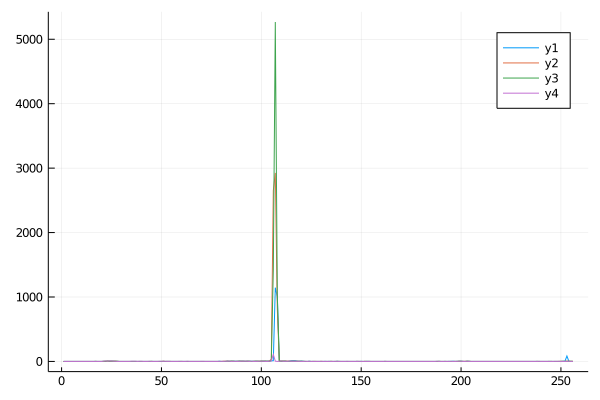

In [9]:
    raster = AG.unsafe_create(
        "band1.tif",
        AG.getdriver("GTiff"),
        width = ArchGDAL.width(dataset),
        height = ArchGDAL.height(dataset),
        nbands = 1,
        dtype = UInt8
    )
    ## assign the projection and transformation parameters
    AG.setgeotransform!(raster, geotransform)
    AG.setproj!(raster, ref)
    
    ## write the raster    
    AG.write!(
        raster,
        new1,  # image to "burn" into the raster
        1,      # update band 1
    )
    AG.destroy(raster)

UndefVarError: UndefVarError: AG not defined

In [21]:
CartesianIndices((2,3))[5][2]

3

In [22]:
landscan_geotransform

6-element Array{Float64,1}:
 -180.0
    0.0083333333333333
    0.0
   89.99999999999929
    0.0
   -0.0083333333333333